# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/alexanderchung/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/alexanderchung/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
# 5 examples

df = pd.DataFrame({'Training Data': train_data[0:5], 'Training Labels': train_labels[0:5]})

print (df)

                                       Training Data  Training Labels
0  Hi,\n\nI've noticed that if you only save a mo...                1
1  \n\nSeems to be, barring evidence to the contr...                3
2  \n >In article <1993Apr19.020359.26996@sq.sq.c...                2
3  I have a request for those who would like to s...                0
4  AW&ST  had a brief blurb on a Manned Lunar Exp...                2


In [4]:
# 1 example full text to see

print (train_data[0])

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


### Part 2

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

In [5]:
# Create vector object

vec = CountVectorizer()

vec_train_data = vec.fit_transform(train_data)

vec_train_data.shape

(2034, 26879)

### 2a 

The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

In [6]:
print ("Vocabulary size is", vec_train_data.shape[1])
print ("Average non-zero features per example is", vec_train_data.nnz//vec_train_data.shape[0])
print ("Fraction of non-zero in matrix is", vec_train_data.nnz/(2034 * 26879))

Vocabulary size is 26879
Average non-zero features per example is 96
Fraction of non-zero in matrix is 0.0035978272269590263


### 2b 

What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

In [7]:
print ("0th is", vec.get_feature_names()[0])
print ("Last is", vec.get_feature_names()[-1])

0th is 00
Last is zyxel


### 2c

Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

In [8]:
# Set vocab

vec_2c = CountVectorizer()
vec_2c.vocabulary = ["atheism", "graphics", "space", "religion"]
vec_train_data_2c = vec_2c.fit_transform(train_data)

# Shape and average

print ("Shape seems reasonable: ",vec_train_data_2c.shape)
print ("Average non-zero features per example is", vec_train_data_2c.nnz/vec_train_data_2c.shape[0])

Shape seems reasonable:  (2034, 4)
Average non-zero features per example is 0.26843657817109146


### 2d

Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

In [9]:
# Set analyzer and ngram range

vec_2d = CountVectorizer(analyzer="char", ngram_range=(2,3))
vec_train_data_2d = vec_2d.fit_transform(train_data)

# Vocab size

print ("Vocabulary size is", vec_train_data_2d.shape[1])

Vocabulary size is 35478


### 2e

Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

In [10]:
# Set min_df

vec_2e = CountVectorizer(min_df=10)
vec_train_data_2e = vec_2e.fit_transform(train_data)

# Vocab size

print ("Vocabulary size is", vec_train_data_2e.shape[1])

Vocabulary size is 3064


### 2f 

Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [11]:
# Set CountVectorizer

vec_2f = CountVectorizer()
vec_train_2f, vec_dev_2f = vec_2f.fit_transform(train_data), vec_2f.fit_transform(dev_data)

# Inspect vocab size and calculate fraction

print ("Fraction missing is", ((vec_train_2f.shape[1] - vec_dev_2f.shape[1])/vec_train_2f.shape[1]))

Fraction missing is 0.395587633468507


### Part 3

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization.

#### Finding optimal K

In [12]:
# Create vector

vec_3 = CountVectorizer()
vec_train_3 = vec_3.fit_transform(train_data)

# Create KNN for k values (odd numbers below 100)

odd_numbers = [i for i in range(1,100) if i%2 != 0]
k_values = {"n_neighbors": odd_numbers}

# GridSearch to find optimal k

model = KNeighborsClassifier()
grid = GridSearchCV(model,k_values,scoring='f1_weighted')
predict_grid = grid.fit(vec_train_3,train_labels)

print ("Optimal k is", predict_grid.best_params_)

Optimal k is {'n_neighbors': 95}


#### Finding optimal alpha

In [13]:
# Alphas (taken from Project 1)

alphas = {"alpha":[0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# Fit multinomial naive bayes

model_mnb = MultinomialNB()
grid_mnb = GridSearchCV(model_mnb,alphas,scoring='f1_weighted')
predict_grid_mnb = grid_mnb.fit(vec_train_3,train_labels)

print ("Optimal alpha is", predict_grid_mnb.best_params_)

/Users/alexanderchung/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/alexanderchung/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/alexanderchung/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Optimal alpha is {'alpha': 0.01}


#### Optimal value for C

In [14]:
# Define C values and create model

c_values = {"C":[0.01, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.99]}
logistic = LogisticRegression(penalty = "l2")

# GridSearch to find optimal C

grid_logistic = GridSearchCV(logistic, c_values)
predict_grid_logistic = grid_logistic.fit(vec_train_3,train_labels)


print ("Optimal C is", predict_grid_logistic.best_params_)

Optimal C is {'C': 0.2}


### 3a

Why doesn't nearest neighbors work well for this problem?

#### Curse of dimensionality where KNN is misfitting high-dimensional data.

### 3b 

Any ideas why logistic regression doesn't work as well as Naive Bayes?

#### It's possible that Naive Bayes may work better on a smaller amount of traning data.

### 3c 

Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [15]:
# Iterate through different values of C

for C in [0.01, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.99]:
        model_3c = LogisticRegression(C=C)
        model_3c.fit(vec_train_3,train_labels)
        sum_weight = np.sum(model_3c.coef_**2, axis=1)        
        print ("For C={}, sum of the squared weight is {}".format(C,sum_weight))

For C=0.01, sum of the squared weight is [ 2.54147847  2.93970937  2.86246884  2.25002921]
For C=0.2, sum of the squared weight is [ 49.74394946  42.74337514  49.32860862  42.66649474]
For C=0.3, sum of the squared weight is [ 69.28241074  57.86865237  67.89889811  59.78284452]
For C=0.4, sum of the squared weight is [ 86.72956992  71.14614227  84.27950863  75.03946457]
For C=0.5, sum of the squared weight is [ 102.59648447   83.11964951   99.0380729    89.00896845]
For C=0.6, sum of the squared weight is [ 117.26159825   94.00631585  112.53089474  101.86963127]
For C=0.7, sum of the squared weight is [ 130.88264326  104.14532113  125.00616875  113.84572574]
For C=0.8, sum of the squared weight is [ 143.60487315  113.61561522  136.6186013   125.10211069]
For C=0.99, sum of the squared weight is [ 165.93165991  130.06071765  156.92407614  144.75888602]


#### The sums appear to increase as the C value increases.

### Part 4

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [16]:
# Create vector 

vec_4 = CountVectorizer()
vec_train_4 = vec_4.fit_transform(train_data)
dev_train_4 = vec_4.transform(dev_data)

# Train logistic

logistic_4 = LogisticRegression()
logistic_4.fit(vec_train_4, train_labels)
logistic_4_predict = logistic_4.predict(dev_train_4)

# Find largest weights and process data

weights = logistic_4.coef_
index_list = map(lambda category: np.argpartition(abs(weights[category]), -5)[-5:], range(4))
index = [i for j in index_list for i in j]
features = [vec_4.get_feature_names()[idx] for idx in index]
largest = [np.round(weights[category][index],2) for category in range(4)]

# Place data into dataframe

df_4 = pd.DataFrame({'Features': features, '1': largest[0], '2': largest[1], '3': largest[2], '4': largest[3]})

print ("Largest Weights")
print (df_4)

Largest Weights
       1     2     3     4    Features
0   0.95 -0.62 -0.79 -0.06    religion
1   0.99 -0.22 -0.34 -0.46       bobby
2   1.03 -0.10 -0.32 -0.83    atheists
3   1.12 -0.40 -0.42 -0.40    deletion
4  -1.26 -1.32  2.16 -1.17       space
5  -0.36  1.13 -0.70 -0.38          3d
6  -0.33  1.27 -0.81 -0.63        file
7  -0.58  1.35 -0.83 -0.47       image
8  -1.26 -1.32  2.16 -1.17       space
9  -0.76  1.94 -1.34 -0.76    graphics
10 -0.47 -0.47  0.94 -0.33      launch
11 -0.57 -0.48  1.01 -0.47        nasa
12 -0.76  1.94 -1.34 -0.76    graphics
13 -1.26 -1.32  2.16 -1.17       space
14 -0.41 -0.67  1.22 -0.63       orbit
15  0.23 -0.13  0.34 -0.93       could
16 -0.53 -0.11 -0.32  1.05       blood
17 -0.61 -0.42 -0.27  1.12   christian
18 -0.74 -0.41 -0.53  1.15  christians
19 -1.26 -1.32  2.16 -1.17       space


#### With Bigram features:

In [17]:
# Create vector 

vec_4_bi = CountVectorizer(ngram_range=(2,2))
vec_train_4_bi = vec_4_bi.fit_transform(train_data)
dev_train_4_bi = vec_4_bi.transform(dev_data)

# Train logistic

logistic_4_bi = LogisticRegression()
logistic_4_bi.fit(vec_train_4_bi, train_labels)
logistic_4_predict_bi = logistic_4_bi.predict(dev_train_4_bi)

# Find largest weights and process data

weights = logistic_4_bi.coef_
index_list = map(lambda category: np.argpartition(abs(weights[category]), -5)[-5:], range(4))
index = [i for j in index_list for i in j]
features = [vec_4_bi.get_feature_names()[idx] for idx in index]
largest = [np.round(weights[category][index],2) for category in range(4)]

# Place data into dataframe

df_4_bi = pd.DataFrame({'Features': features, '1': largest[0], '2': largest[1], '3': largest[2], '4': largest[3]})

print ("Largest Weights - Bigram")
print (df_4_bi)

Largest Weights - Bigram
       1     2     3     4        Features
0   0.63 -0.24 -0.20 -0.17         look up
1   0.65 -0.88 -0.82  0.60     cheers kent
2   0.77 -0.26 -0.35 -0.20      claim that
3   0.68 -0.19 -0.20 -0.30        was just
4  -0.76  1.32 -0.61 -0.70     looking for
5  -0.32  0.90 -0.58 -0.33       out there
6  -0.38  1.04 -0.47 -0.40   comp graphics
7  -0.43  0.91 -0.57 -0.34        is there
8  -0.76  1.32 -0.61 -0.70     looking for
9  -0.54  0.97 -0.53 -0.51      in advance
10 -0.24 -0.40  0.69 -0.26        and such
11 -0.32 -0.39  0.74 -0.27       sci space
12 -0.40 -0.58  0.95 -0.24        the moon
13 -0.31 -0.65  1.03 -0.32       the space
14  0.65 -0.88 -0.82  0.60     cheers kent
15 -0.17 -0.26 -0.36  0.65         the fbi
16 -0.13 -0.21 -0.20  0.70  compuserve com
17 -0.76  1.32 -0.61 -0.70     looking for
18 -0.15 -0.22 -0.19  0.71     such lunacy
19 -0.23 -0.25 -0.21  0.75    ignorance is


### Part 5 

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [18]:
# Simple processing function

def better_preprocessor(s):

    ## lowercase
    s = s.lower()
    ## remove non-letter chars
    s = re.sub("[^a-zA-Z\s]", "", s)
    return s

In [19]:
# No processing

vec_5 = CountVectorizer()
vec_train_5 = vec_5.fit_transform(train_data)
dev_train_5 = vec_5.transform(dev_data)

# Train logistic

logistic_5 = LogisticRegression()
logistic_5.fit(vec_train_5, train_labels)
logistic_5_predict = logistic_5.predict(dev_train_5)

# Get score

print ("Score w/ NO preprocess:", metrics.f1_score(dev_labels,logistic_5_predict,average='weighted'))

Score w/ NO preprocess: 0.694417287185


In [20]:
# WITH processing

vec_5_processed = CountVectorizer(preprocessor=better_preprocessor)
vec_train_5_processed = vec_5_processed.fit_transform(train_data)
dev_train_5_processed = vec_5_processed.transform(dev_data)

# Train logistic

logistic_5_processed = LogisticRegression()
logistic_5_processed.fit(vec_train_5_processed, train_labels)
logistic_5_predict_processed = logistic_5_processed.predict(dev_train_5_processed)

# Get score

print ("Score WITH preprocess:", metrics.f1_score(dev_labels,logistic_5_predict_processed,average='weighted'))

# Dictionary reduction

print ("Size reduced by", len(vec_5.vocabulary_)-len(vec_5_processed.vocabulary_))

Score WITH preprocess: 0.683311427905
Size reduced by 96


#### With just lowercase and substitution non-letter characters, the f1 actually went down. I reduced the dictionary size by only 96. 

### Part 6 

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [21]:
# Create vector

vec_6 = CountVectorizer()
vec_train_6 = vec_6.fit_transform(train_data)
dev_train_6 = vec_6.transform(dev_data)

# Train logistic w/ L1

logistic_6_l1 = LogisticRegression(penalty="l1", C=0.2, tol=0.01)
logistic_6_l1.fit(vec_train_6, train_labels)
logistic_6_l1_predict = logistic_6_l1.predict(dev_train_6)

# Train logistic w/ L2

logistic_6_l2 = LogisticRegression(penalty="l2", C=0.2, tol=0.01)
logistic_6_l2.fit(vec_train_6, train_labels)
logistic_6_l2_predict = logistic_6_l2.predict(dev_train_6)

# Compare non-zeros

print ("# of Non Zero for L1: ", np.count_nonzero(logistic_6_l1.coef_))
print ("# of Non Zero for L2: ", np.count_nonzero(logistic_6_l2.coef_))

# of Non Zero for L1:  649
# of Non Zero for L2:  107516


In [22]:
# Create list of vocab items that contain at least 1 non-zero weight

vocab = vec_6.vocabulary_
weights = logistic_6_l1.coef_
vocab_nonzeros = []

for item in vocab:
    i = vocab.get(str(item))
    if weights[0,i] !=0 or weights[1,i] != 0 or weights[2,i] != 0 or weights[3,i] != 0:
        vocab_nonzeros.append(item)
        
# Create new vector with moidified vocab

vec_6_new = CountVectorizer(vocabulary=vocab_nonzeros)
vec_train_6_new = vec_6_new.fit_transform(train_data)
dev_train_6_new = vec_6_new.transform(dev_data)

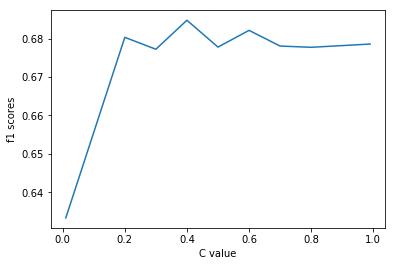

In [23]:
# Re-construct model with new vocab and optimal C value

accuracy = []
c_values = [0.01, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.99]

for C in [0.01, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.99]:
    
    logistic_temp = LogisticRegression(penalty="l2", C=C, tol=0.01)
    logistic_temp.fit(vec_train_6_new, train_labels)
    logistic_temp_predict = logistic_temp.predict(dev_train_6_new)
    
    accuracy.append(metrics.f1_score(dev_labels,logistic_temp_predict,average='weighted'))
    
plt.plot(c_values, accuracy)    
plt.xlabel("C value") 
plt.ylabel("f1 scores") 

### Part 7

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [24]:
# Create vector with TfidfVectorizer

vec_7 = TfidfVectorizer()
vec_7_train = vec_7.fit_transform(train_data)
vec_7_dev = vec_7.transform(dev_data)

# Train logistic

logistic_7 = LogisticRegression(C=100)
logistic_7.fit(vec_7_train, train_labels)
logistic_7_predict = logistic_7.predict(vec_7_dev)

# Show top 3 documents according to R values

proba = logistic_7.predict_proba(vec_7_dev)

r_values = np.zeros(len(proba))

for row in range(len(proba)):
    probs = proba[row]
    r_values[row] = float(np.max(probs))/float(probs[dev_labels[row]])

largest = np.argsort(r_values)[-3:]

print ("Top 3 documents:")

for i in largest:
    print ("\n" + dev_data[i] + "\n" + "------------------------------------------" + "\n")

Top 3 documents:


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

------------------------------------------


Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
------------------------------------------


I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-pro

[[102  11  19  33]
 [  5 168  10   2]
 [ 10  20 165   4]
 [ 31  10   5  81]]


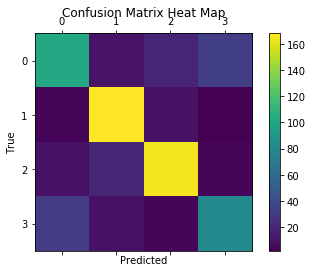

In [25]:
# Produce simple confusion matrix

cm = confusion_matrix(dev_labels, logistic_7_predict)
print(cm)


# Produce confusion matrix heatmap for extra clarity

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix Heat Map')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Has a lot of toruble predicting the third example.